In [2]:
import os
from os import listdir
from os.path import isfile, join
import pickle
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
sns.set_style("whitegrid", {"axes.grid": False})

In [3]:
base = 'aida'
extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud','dandelion', 'babelfy', 'textrazor']
extractors_disambiguation = ['dandelion', 'babelfy', 'textrazor']


In [4]:
extractors_types.sort()
extractors_disambiguation.sort()

In [5]:
from sklearn.metrics import accuracy_score,f1_score

def evaluate_prediction(Y,standard_gold_list,predicted,uris_list_per_extractor_flatten,extractors_disambiguation_out):
    eval_obj = dict()
    uri_list=FromPreditedToURIs(predicted,uris_list_per_extractor_flatten,extractors_disambiguation_out)
    best_flatten = getBestResult(uris_list_per_extractor_flatten,standard_gold_list)
    eval_obj['score_disambiguation']=getScoresDisambiguation(standard_gold_list,uri_list)
    eval_obj['score_disambiguation_best']=getScoresDisambiguation(best_flatten,uri_list)
    predicted_round = predicted.round()
    uri_list_round = FromPreditedToURIs(predicted_round,uris_list_per_extractor_flatten,extractors_disambiguation_out)
    eval_obj['score_disambiguation_round']=getScoresDisambiguation(standard_gold_list,uri_list_round)
    eval_obj['score_disambiguation_best_round']=getScoresDisambiguation(best_flatten,uri_list_round)
    eval_obj['accuracy'] = accuracy_score(Y,predicted_round)
    eval_obj['f1_NN'] = dict()
    Y_t = np.transpose(Y)
    predicted_round_t = np.transpose(predicted_round)
    for i,ext in enumerate(extractors_disambiguation_out):
        eval_obj['f1_NN'][ext]=f1_score(Y_t[i],predicted_round_t[i])
    eval_obj['f1_NN']['weighted'] = np.mean([eval_obj['f1_NN'][ext] for ext in eval_obj['f1_NN']])
    return eval_obj


def FromPreditedToURIs(predicted,uris_list_per_extractor_flatten,rounding=False):
    extractors = list(uris_list_per_extractor_flatten[0].keys())
    extractors.sort()
    uri_list_end= list()
    if rounding:
        predicted = predicted.round()
    for k,line in enumerate(predicted):
        obj = uris_list_per_extractor_flatten[k]
        if len(set(line)) == 1 and line[0]==0:
            line = [1 for z in range(len(line))]
        line_dict = dict()
        for j,ext in enumerate(extractors):
            uri = obj[ext]
            if type(uri) == float:
                uri = '0'
            if uri in line_dict:
                line_dict[obj[ext]] += line[j]
            else:
                line_dict[obj[ext]] = line[j]
        #print(line_dict)
        selected = max(line_dict, key=line_dict.get)
        if selected == '0':
            selected = np.NAN
        uri_list_end.append(selected)
    return uri_list_end


def getScoresDisambiguation(standard_gold_list,predicted_list):
    true_negative = 0 
    true_positive = 0
    false_negative = 0
    false_positive = 0
    for i in range(len(standard_gold_list)):
        item_gold, item = standard_gold_list[i],predicted_list[i]
        if type(item_gold) != str and type(item) != str:
            true_negative += 1
        elif type(item_gold) == str and type(item) != str:
            false_negative += 1
        elif type(item_gold) != str and type(item) == str:
            false_positive += 1
        elif type(item_gold) == str and type(item) == str:
            if item == item_gold:
                true_positive += 1
            else:
                false_positive += 1
                false_negative += 1
    precision = true_positive / (true_positive+false_positive)
    recall = true_positive / (true_positive+false_negative)
    f1 = 2*(precision* recall)/(precision + recall)
    score_obj = {
        'precision':precision,
        'recall':recall,
        'f1':f1
    }
    return score_obj




def getUrisListPerFile(predicted,features_paths):
    uri_list_end= list()
    predicted_round = predicted.round()
    for j,f in enumerate(predicted_round):
        f_p = features_paths[j]
        uri_list_per_file= []
        obj = pickle.load(open(f_p,'rb'))
        uri_list = obj['uris_list']
        for k,line in enumerate(f[:len(uri_list['dandelion'])]):
            line_dict = dict()
            if 1 in line:
                for i,l in enumerate(line):
                    uri= obj['uris_list'][extractors_disambiguation[i]][k]
                    if type(uri) == float:
                        if '0' in line_dict: 
                            line_dict['0'] += l
                        else:
                            line_dict['0'] = l
                    else:  
                        if uri in line_dict: 
                            line_dict[uri] += l
                        else:
                            line_dict[uri] = l
                #print(line_dict)
                selected = max(line_dict, key=line_dict.get)
                if selected == '0':
                    selected = np.NAN
            else:
                selected = np.NAN
            uri_list_per_file.append(selected)
        uri_list_end.append(uri_list_per_file)
    return uri_list_end


def getURISListGT(groundtruth_paths):
    uris_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        uris = list()
        for r in recs_gt:
            uri = r['wd_uri']
            uris.append(uri)
        uris_df_per_file.append(uris)
    return uris_df_per_file


def setURI(t):
    if bool(t) and type(t)==str:
        return t
    else:
        return np.NAN
    
def getURISListPerExtractor(features_paths,extractor_list=['dandelion', 'dbspotlight', 'babelfy', 'textrazor']):
    uris_list_per_extractor = list()
    for j,f in enumerate(features_paths):
        uri_list_file = list()
        obj = pickle.load(open(f,'rb'))
        uri_list = obj['uris_list']
        uris_list_per_extractor.append([{ext:setURI(uri_list[ext][i]) for ext in uri_list if ext in extractor_list} for i in range(len(uri_list['dandelion']))])
    return uris_list_per_extractor


def getURIListExt(features_paths,ext):
    uris_list_per_extractor = getURISListPerExtractor(features_paths,extractor_list=[ext])
    for i,f in enumerate(uris_list_per_extractor):
        for j,item in enumerate(f):
            uris_list_per_extractor[i][j] = item[ext]
    return uris_list_per_extractor
    

def getBestResult(uris_list_per_extractor_flatten,gt_test_flatten):
    best_result = list()
    for j,uri in enumerate(gt_test_flatten):
        if True in [uris_list_per_extractor_flatten[j][key]==uri for key in uris_list_per_extractor_flatten[j]]:
            best_result.append(uri)
        else:
            best_result.append(np.NAN)
    return best_result

def getTextList(groundtruth_paths):
    text_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        texts = list()
        for r in recs_gt:
            text = r['text']
            texts.append(text)
        text_df_per_file.append(texts)
    return text_df_per_file


def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file


def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str and bool(t):
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file



def getTYPESListPerExtractor(features_paths,extractor_list=['alchemy', 'adel', 'opencalais', 'meaning_cloud','textrazor']):
    ext_dict_type = {ext:getTypeExtractor(ext,features_paths) for ext in extractor_list}
    type_list_per_exractor = list()
    for i in range(len(ext_dict_type[extractor_list[0]])):
        type_list_per_exractor_p = list()
        for j in range(len(ext_dict_type[extractor_list[0]][i])):
            type_list_per_exractor_p.append({ext:ext_dict_type[ext][i][j] for ext in extractor_list})
        type_list_per_exractor.append(type_list_per_exractor_p)
    return type_list_per_exractor


def isSameUri(wd1,wd2):
    return int((type(wd1)==type(wd2)==float) or (wd1==wd2))


def getDFEvaluation(uris_list_per_extractor_flatten,type_list_per_extractor_flatten,
                    gt_list_flatten_type,gt_list_flatten_uri,text_list_flatten):
    
    if not (len(uris_list_per_extractor_flatten) == len(type_list_per_extractor_flatten)
        == len(gt_list_flatten_uri) == len(gt_list_flatten_type) == len(text_list_flatten)):
        print(len(uris_list_per_extractor_flatten),len(type_list_per_extractor_flatten),
              len(gt_list_flatten_type),len(gt_list_flatten_uri),len(text_list_flatten))
        raise Exception
    len_ = len(gt_list_flatten_uri)
    records = list()
    for i in range(len_):
        rec = dict()
        rec['count_rights'] = 0
        rec['uri_GT'] = gt_list_flatten_uri[i]
        for key in uris_list_per_extractor_flatten[i]:
            rec['uri_'+key] = uris_list_per_extractor_flatten[i][key]
            rec['count_rights'] += int(rec['uri_GT']==rec['uri_'+key]) or (type(rec['uri_GT'])==type(rec['uri_'+key])==float)
        
        
     
        for key in type_list_per_extractor_flatten[i]:
            rec['type_'+key] = type_list_per_extractor_flatten[i][key]
        
        rec['type_GT'] = gt_list_flatten_type[i]
        
        rec['text'] = text_list_flatten[i]
        records.append(rec)
    df = pd.DataFrame(records)
    df = df.fillna(value='0')
    return df

def builtXY(uris_list_per_extractor_flatten,extractors_disambiguation_in,extractors_disambiguation,
            extractors_disambiguation_out,gt_flatten):
    X = []
    Y = []
    for i,line in enumerate(uris_list_per_extractor_flatten):
        X.append([isSameUri(line[key_1],line[key_2]) 
         for key_1 in extractors_disambiguation_in 
         for key_2 in extractors_disambiguation])
        Y.append([isSameUri(line[ext],gt_flatten[i])
                        for ext in extractors_disambiguation_out])

    X = np.array(X)
    Y = np.array(Y)
    return X,Y

def createModelObject(extractors_disambiguation_in,extractors_disambiguation,extractors_disambiguation_out,
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test
                     ):
    model_obj = {
        'features_paths_train':features_paths_train,
        'features_paths_test':features_paths_test,
        'extractors_disambiguation_in':extractors_disambiguation_in,
        'extractors_disambiguation':extractors_disambiguation,
        'extractors_disambiguation_out':extractors_disambiguation_out
    }
    
    
    model_obj['train_X']= X_train
    model_obj['train_Y']= Y_train
    model_obj['train_GT']= gt_train_flatten
    model_obj['train_EXT']= uris_list_per_extractor_train_flatten
    model_obj['train_GT_best'] = getBestResult(uris_list_per_extractor_train_flatten,gt_train_flatten)
    model_obj['train_Y_best'] = builtXY(uris_list_per_extractor_train_flatten,extractors_disambiguation_in,
                                        extractors_disambiguation,extractors_disambiguation_out,model_obj['train_GT_best'])
    
    model_obj['test_X']= X_test
    model_obj['test_Y']= Y_test
    model_obj['test_GT']= gt_test_flatten
    model_obj['test_EXT']= uris_list_per_extractor_test_flatten
    model_obj['test_GT_best'] = getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten)
    model_obj['test_Y_best'] = builtXY(uris_list_per_extractor_test_flatten,extractors_disambiguation_in,
                                        extractors_disambiguation,extractors_disambiguation_out,model_obj['test_GT_best'])
        
    
    return model_obj

def saveModelObj(model_obj,path):        
    pickle.dump( model_obj, open( path, "wb" ) )
def readModelObj(path):
    return pickle.load(open(path,'rb'))


def generateHistogram(x,ext_names,count_rights_names):
    colors = ['r','y','g','b','m']
    N = len(x)
    x = np.transpose(x)


    ind = np.arange(N)  # the x locations for the groups
    width = 0.2      # the width of the bars

    fig, ax = plt.subplots(figsize=(20,9))
    recs = [ax.bar(ind+width*i,tuple(x[i]), width, color=colors[i]) for i in range(len(ext_names))]
    

    # add some text for labels, title and axes ticks
    #ax.set_ylabel('Scores')
    #ax.set_title('Scores by extractor')
    #ax.set_xticks(ind + width)
    print(count_rights_names)
    ax.set_xticklabels(['','1','','2','','3','','4'])

    ax.legend(tuple([rec[0] for rec in recs]), tuple(ext_names))
    


    plt.show()
    

def getRelationshipExtractorDF_obj(uris_list_per_extractor_flatten,test_list,display_flag=True,paths=[None,None]):
    test_list_best = getBestResult(uris_list_per_extractor_flatten,test_list)
    ext_obj = {
        'GT':test_list,
        'GT_best':test_list_best
    }
    for key in uris_list_per_extractor_flatten[0]:
        ext_obj[key] = [l[key] for l in uris_list_per_extractor_flatten]
        ext_obj[key+'_best'] = getBestResult([{key:l[key]} for l in uris_list_per_extractor_flatten],test_list)
    ext_obj_rel = dict()
    correlation_matrix_1 = []
    correlation_matrix_2 = []
    names_1 = []
    names_2 = []
    for key_1 in ext_obj:
        records = list()
        correlation_matrix_1_p = []
        correlation_matrix_2_p = []
        for key_2 in ext_obj:
            obj = getScoresDisambiguation(ext_obj[key_2],ext_obj[key_1])
            obj['extractor'] = key_2
            records.append(obj)
            if 'best' in key_1 and not 'GT' in key_1 and 'best' in key_2 and 'GT' not in key_2:
                correlation_matrix_1_p.append(obj['f1'])
            if 'best' not in key_1 and not 'GT' in key_1 and 'best' not in key_2 and 'GT' not in key_2:
                correlation_matrix_2_p.append(obj['f1'])
        if 'best' in key_1 and not 'GT' in key_1:
            names_1.append(key_1)
        if 'best' not in key_1 and not 'GT' in key_1:
            names_2.append(key_1)
        if bool(correlation_matrix_1_p):
            correlation_matrix_1.append(correlation_matrix_1_p)
        if bool(correlation_matrix_2_p):
            correlation_matrix_2.append(correlation_matrix_2_p)
        ext_obj_rel[key_1]=pd.DataFrame(records)
    
    getHeatMap(correlation_matrix_1,names_1,paths[0])
    getHeatMap(correlation_matrix_2,names_2,paths[1])
    if display_flag:
        for key in ext_obj_rel:
            print(key)
            display(ext_obj_rel[key])
    
    return ext_obj_rel

def getHeatMap(correlation_matrix,names,path=None):
    np.random.seed(0)
    fig = plt.figure(figsize=(10,5))
    uniform_data = np.array(correlation_matrix)
    ax = sns.heatmap(uniform_data,xticklabels=names, yticklabels=names,center=0.5,annot=True,vmin=0, vmax=1, cmap="gray")
    ax.xaxis.tick_top()
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#999999')
    plt.yticks(rotation=0)
    plt.tight_layout()
    if bool(path):
        fig.savefig(path) 
    plt.show()
    
    
    
def addExtractorsTypesRepresentation(model_obj,extractors_types):
    candidates_test_iter = iter(model_obj['candidates_test'])
    candidates_train_iter = iter(model_obj['candidates_train'])
    paths_test = model_obj['features_paths_test']
    paths_train = model_obj['features_paths_train']
    model_obj['extractors_types'] = extractors_types
    model_obj['type_dict_test'] = {ext:[] for ext in extractors_types}
    model_obj['type_dict_train'] = {ext:[] for ext in extractors_types}
    for p in paths_test:
        obj = pickle.load(open(p,'rb'))
        features_obj = obj['features']['type']
        flag_g = True
        for ext in extractors_types:
            if flag_g:
                repeats = [len(next(candidates_test_iter)) for line in obj['features']['type'][ext]]
                flag_g = False
            for j,line in enumerate(obj['features']['type'][ext]):
                for k in range(repeats[j]):
                    model_obj['type_dict_test'][ext].append(line)
    
    for p in paths_train:
        obj = pickle.load(open(p,'rb'))
        features_obj = obj['features']['type']
        flag_g = True
        for ext in extractors_types:
            if flag_g:
                repeats = [len(next(candidates_train_iter)) for line in obj['features']['type'][ext]]
                flag_g = False
            for j,line in enumerate(obj['features']['type'][ext]):
                for k in range(repeats[j]):
                    model_obj['type_dict_train'][ext].append(line)
    for ext in extractors_types:
        model_obj['type_dict_test'][ext] = np.array(model_obj['type_dict_test'][ext])
        model_obj['type_dict_train'][ext] = np.array(model_obj['type_dict_train'][ext])
    return model_obj


def generateHistograM(x,path,ext_names):
    N = len(x)
    x = np.transpose(x)
    f1_score = tuple(x[0])
    precision = tuple(x[1])
    recall = tuple(x[2])


    ind = np.arange(N)  # the x locations for the groups
    width = 0.3      # the width of the bars

    fig, ax = plt.subplots(figsize=(20,9))

    rects1 = ax.bar(ind, f1_score, width, color='r')

    rects2 = ax.bar(ind + width, precision, width, color='y')

    rects3 = ax.bar(ind + width*2, recall, width, color='g')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_title('Scores by extractor')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(tuple(ext_names+['combination']))

    ax.legend((rects1[0], rects2[0],rects3[0]), ('F1_score', 'Precision','Recall'))
    
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '',
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.savefig(path, dpi=600)
    plt.show()


def getPlots_and_Results(features_paths_test,features_paths_train,extractors_disambiguation,gt_test_flatten,
                        gt_train_flatten,uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,
                        extractors_indexes):
    
    models_path_folder = 'disambiguation_models/'
    
    output_models_extractors = {'test':dict(),'train':dict()}
    records_train = []
    for_hist_train = dict()
    
    for ext in extractors_disambiguation:
        list_ext = getURIListExt(features_paths_train,ext)
        list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
        output_models_extractors['train'][ext] = list_ext_flatten
        scores_disambiguation_obj = getScoresDisambiguation(gt_train_flatten,list_ext_flatten)
        for_hist_train[ext] = scores_disambiguation_obj
        scores_disambiguation_obj['extractor']=ext
        records_train.append(scores_disambiguation_obj)

    df_eval_ext_train=pd.DataFrame(records_train)

    writer = pd.ExcelWriter('disambiguation_images/extracors_scores_train.xlsx')
    df_eval_ext_train.to_excel(writer)
    writer.save()
    display(df_eval_ext_train)
    
    records_test = []
    for_hist_test = dict()
    
    for ext in extractors_disambiguation:
        list_ext = getURIListExt(features_paths_test,ext)
        list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
        output_models_extractors['test'][ext] = list_ext_flatten
        scores_disambiguation_obj = getScoresDisambiguation(gt_test_flatten,list_ext_flatten)
        for_hist_test[ext] = scores_disambiguation_obj
        scores_disambiguation_obj['0_extractor']=ext
        records_test.append(scores_disambiguation_obj)

    df_eval_ext_test=pd.DataFrame(records_test)

    writer = pd.ExcelWriter('disambiguation_images/extracors_scores_test.xlsx')
    df_eval_ext_test.to_excel(writer)
    writer.save()
    display(df_eval_ext_test)
    
    best_result_test = getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten)
    print('Max scores test:',getScoresDisambiguation(gt_test_flatten,best_result_test))
    
    best_result_train = getBestResult(uris_list_per_extractor_train_flatten,gt_train_flatten)
    print('Max scores train:',getScoresDisambiguation(gt_train_flatten,best_result_train))
    
    
    ext_obj_rel_test = getRelationshipExtractorDF_obj(uris_list_per_extractor_test_flatten,gt_test_flatten,display_flag=False,
                                                      paths=['disambiguation_images/ext_relathionship_test_1.png',
                                                             'disambiguation_images/ext_relathionship_test_2.png'
                                                            ])
    
    ext_obj_rel_train = getRelationshipExtractorDF_obj(uris_list_per_extractor_train_flatten,gt_train_flatten,display_flag=False,
                                                      paths=['disambiguation_images/ext_relathionship_train_1.png',
                                                             'disambiguation_images/ext_relathionship_train_2.png'
                                                            ])
    
    

    
    records_train = []
    records_test = []
    
    for index in extractors_indexes:
        model_obj = pickle.load(open(models_path_folder+index+'.p','rb'))
        P = model_obj['predicted_test']
        uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
        output_models_extractors['test'][index] = uri_list
        obj = getScoresDisambiguation(gt_test_flatten,uri_list)
        for_hist_train[index] = obj
        obj['0_MODEL']=index
        f1 = f1_score(np.squeeze(model_obj['test_Y']),np.squeeze(P).round())
        acc = accuracy_score(np.squeeze(model_obj['test_Y']),np.squeeze(P).round())
        obj['f1_NN'] = f1
        obj['accuracy_NN'] = acc
        records_test.append(obj)
        
        P = model_obj['predicted_train']
        uri_list =getLISTPREDICTED(P,model_obj['candidates_train'])
        output_models_extractors['train'][index] = uri_list
        obj = getScoresDisambiguation(gt_train_flatten,uri_list)
        for_hist_test[index] = obj
        obj['0_MODEL']=index
        f1 = f1_score(np.squeeze(model_obj['train_Y']),np.squeeze(P).round())
        acc = accuracy_score(np.squeeze(model_obj['train_Y']),np.squeeze(P).round())
        obj['f1_NN'] = f1
        obj['accuracy_NN'] = acc
        records_train.append(obj)
        
    df_eval_ext_train=pd.DataFrame(records_train)

    writer = pd.ExcelWriter('disambiguation_images/models_scores_train.xlsx')
    df_eval_ext_train.to_excel(writer)
    writer.save()
    display(df_eval_ext_train)
    
    df_eval_ext_test=pd.DataFrame(records_test)

    writer = pd.ExcelWriter('disambiguation_images/models_scores_test.xlsx')
    df_eval_ext_test.to_excel(writer)
    writer.save()
    display(df_eval_ext_test)
    
    output_models_extractors['test']['GT'] =  gt_test_flatten
    output_models_extractors['train']['GT'] =  gt_train_flatten
    
    
    for key in output_models_extractors:
        df = pd.DataFrame(output_models_extractors[key])
        writer = pd.ExcelWriter('disambiguation_images/outputs_'+key+'.xlsx')
        df.to_excel(writer)
        writer.save()
        display(df)
        df = df.fillna('0')
        for index in extractors_indexes:
            df_wrong = df[df[index]!=df['GT']]
            writer = pd.ExcelWriter('disambiguation_images/outputs_'+key+'_wrong_'+index+'.xlsx')
            df_wrong.to_excel(writer)
            writer.save()
        
    lables_test = [key for key in for_hist_test]
    x_test = [[for_hist_test[key][sc] for sc in ['f1','precision','recall']] for key in for_hist_test]
    generateHistograM(x_test,'disambiguation_images/hist_test.png',lables_test)
    lables_train = [key for key in for_hist_train]
    x_train= [[for_hist_train[key][sc] for sc in ['f1','precision','recall']] for key in for_hist_train]
    generateHistograM(x_train,'disambiguation_images/hist_train.png',lables_train)

def createModelObject_b(extractors_disambiguation,
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test,candidates_train,candidates_test
                     ):
    model_obj = {
        'features_paths_train':features_paths_train,
        'features_paths_test':features_paths_test,
        'extractors_disambiguation':extractors_disambiguation
    }
    
    model_obj['candidates_train'] = candidates_train
    model_obj['candidates_test'] = candidates_test
    model_obj['train_X']= np.array(X_train)
    model_obj['train_Y']= np.array(Y_train)
    model_obj['train_GT']= gt_train_flatten
    model_obj['train_EXT']= uris_list_per_extractor_train_flatten
    model_obj['train_GT_best'] = getBestResult(uris_list_per_extractor_train_flatten,gt_train_flatten)
    model_obj['train_Y_best'] = builtXY_b(uris_list_per_extractor_train_flatten,extractors_disambiguation,model_obj['train_GT_best'])
    model_obj['test_X']= np.array(X_test)
    model_obj['test_Y']= np.array(Y_test)
    model_obj['test_GT']= gt_test_flatten
    model_obj['test_EXT']= uris_list_per_extractor_test_flatten
    model_obj['test_GT_best'] = getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten)
    model_obj['test_Y_best'] = builtXY_b(uris_list_per_extractor_test_flatten,extractors_disambiguation,model_obj['test_GT_best'])
    
    
    return model_obj

def ConcatenateArray(list_arrays):
    array = list()
    for l in list_arrays:
        array += l
    return array

def builtXY_b(uris_list_per_extractor_flatten,extractors_disambiguation,gt_flatten):
    X = []
    Y = []
    candidates_list = []
    for i,line in enumerate(uris_list_per_extractor_flatten):
        
        candidates = set([line[ext] for ext in extractors_disambiguation if type(line[ext])==str])
        if True in [type(line[ext]) == float for ext in extractors_disambiguation]:
            candidates.add(np.NAN)
        candidates = list(candidates)
        candidates.sort(key=lambda x:str(x))
        X_p = [ConcatenateArray([[isSameUri(line[ext_1],uri)] for ext_1 in extractors_disambiguation])
               for uri in candidates]
        Y_p = [[isSameUri(uri,gt_flatten[i])]
               for uri in candidates]
        candidates_list.append(candidates)
        X += X_p
        Y += Y_p
    #X = np.array(X)
    Y = np.array(Y)
    return X,Y,candidates_list


def builtXY_b_complete(uris_list_per_extractor_flatten,extractors_disambiguation,gt_flatten,similarities_dict):
    X = []
    Y = []
    candidates_list = []
    for i,line in enumerate(uris_list_per_extractor_flatten):
        candidates = set([line[ext] for ext in extractors_disambiguation if type(line[ext])==str])
        if True in [type(line[ext]) == float for ext in extractors_disambiguation]:
            candidates.add(np.NAN)
        candidates = list(candidates)
        candidates.sort(key=lambda x:str(x))
        X_p = [ConcatenateArray([similarities_dict[(str(line[ext_1]),str(uri))] for ext_1 in extractors_disambiguation])
               for uri in candidates]
        Y_p = [[isSameUri(uri,gt_flatten[i])]
               for uri in candidates]
        candidates_list.append(candidates)
        X += X_p
        Y += Y_p
    X = np.array(X)
    Y = np.array(Y)
    return X,Y,candidates_list

def get_similarities_dict(features_paths_train,features_paths_test):
    sim_dict = dict()
    features_paths = features_paths_train+features_paths_test
    for i,f in enumerate(features_paths):
        similarites = pickle.load(open(f,'rb'))['features']['uris_MATRIX']
        for item in similarites.items():
            sim_dict[(str(item[0][0]),str(item[0][1]))] = item[1]
            sim_dict[(str(item[0][1]),str(item[0][0]))] = item[1]
    return sim_dict

def getLISTPREDICTED(P,candidates):
    count = 0
    list_uris = []
    for item in candidates:
        pred_obj = {}
        for uri in item:
            pred_obj[uri] = P[count][0]
            count += 1
        if 1 in [round(v) for v in list(pred_obj.values())]:
            selected = max(pred_obj, key=pred_obj.get)
        else:
            selected = np.NAN
        list_uris.append(selected)
    return list_uris

def evaluate_prediction_b(P,Y,candidates,standard_gold_list,uris_list_per_extractor_flatten):
    eval_obj = dict()
    uri_list = getLISTPREDICTED(P,candidates)
    best_flatten = getBestResult(uris_list_per_extractor_flatten,standard_gold_list)
    eval_obj['score_disambiguation']=getScoresDisambiguation(standard_gold_list,uri_list)
    eval_obj['score_disambiguation_best']=getScoresDisambiguation(best_flatten,uri_list)
    eval_obj['accuracy'] = accuracy_score(np.squeeze(Y),np.squeeze(P).round())
    eval_obj['f1_NN'] = f1_score(np.squeeze(Y),np.squeeze(P).round())
    return eval_obj

In [6]:
training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

text_folder_train = training_folder + 'train/txt_files/'
text_folder_test = training_folder + 'test/txt_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()
features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()

texts_paths_train = [path.replace(features_folder_train,text_folder_train).replace('.p','.txt') for path in features_paths_train]
texts_paths_train.sort()
texts_paths_test = [path.replace(features_folder_test,text_folder_test).replace('.p','.txt') for path in features_paths_test]
texts_paths_test.sort()

texts_test = getTextList(groundtruth_paths_test)
texts_flatten_test = reduce(lambda x,y: x+y,texts_test)

texts_train = getTextList(groundtruth_paths_train)
texts_flatten_train = reduce(lambda x,y: x+y,texts_train)

gt_test = getURISListGT(groundtruth_paths_test)
gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
gt_train = getURISListGT(groundtruth_paths_train)
gt_train_flatten = reduce(lambda x,y: x+y,gt_train)


gt_test_type = getTypesListGT(groundtruth_paths_test)
gt_test_flatten_type = reduce(lambda x,y: x+y,gt_test)
gt_train_type = getTypesListGT(groundtruth_paths_train)
gt_train_flatten_type = reduce(lambda x,y: x+y,gt_train)

uris_list_per_extractor_train = getURISListPerExtractor(features_paths_train)
uris_list_per_extractor_train_flatten = reduce(lambda x,y: x+y,uris_list_per_extractor_train)
uris_list_per_extractor_test = getURISListPerExtractor(features_paths_test)
uris_list_per_extractor_test_flatten = reduce(lambda x,y: x+y,uris_list_per_extractor_test)
gt_test_flatten_best = getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten)

type_list_per_extractor_train = getTYPESListPerExtractor(features_paths_train)
type_list_per_extractor_train_flatten = reduce(lambda x,y: x+y,type_list_per_extractor_train)

type_list_per_extractor_test = getURISListPerExtractor(features_paths_test)
type_list_per_extractor_test_flatten = reduce(lambda x,y: x+y,type_list_per_extractor_test)

In [7]:
try:
    os.makedirs('training_data/'+base+'/models/best_dis/')
except:
    pass

In [8]:
similarities_dict = get_similarities_dict(features_paths_train,features_paths_test)
X_train,Y_train,candidates_train = builtXY_b_complete(uris_list_per_extractor_train_flatten,extractors_disambiguation,gt_train_flatten,similarities_dict)
X_test,Y_test,candidates_test = builtXY_b_complete(uris_list_per_extractor_test_flatten,extractors_disambiguation,gt_test_flatten,similarities_dict)

model_obj = createModelObject_b(extractors_disambiguation,
                      X_test,X_train,Y_test,Y_train,
                      gt_test_flatten,gt_train_flatten,
                      uris_list_per_extractor_train_flatten,uris_list_per_extractor_test_flatten,features_paths_train,
                      features_paths_test,candidates_train,candidates_test
                     )

model_obj = addExtractorsTypesRepresentation(model_obj,extractors_types)




In [9]:
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense,Input,concatenate
from keras.layers import LSTM
from keras.layers import GRU,Concatenate
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys

from sklearn.metrics import f1_score as f1_score_func

from sklearn.metrics import accuracy_score

reg_alpha = 0.000
dropout = 0.45
dropout_input = 0.0
epochs=1000
batch=50
eg_alpha=0.0 
units=400
layers=2
#loss_function = 'categorical_crossentropy'
loss_function = 'mse'
optimizer = 'adam'
#activation = 'softmax'
activation = 'sigmoid'
activation_middle = 'selu'
architecture = 'simple'
patience = 50
dim_concatenation = 5


model_file_path = 'training_data/'+base+'/models/best_dis/model.h5'

class TestCallback(Callback):
    def __init__(self):
        self.history_scores = list()
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj
        x, y = model_obj['X_dict_test'],model_obj['Y_dict_test']
        val_loss = model.evaluate(x,y)[0]
        predicted_test = self.model.predict(x,verbose=0)
        score_obj = dict()


        score_obj['val_loss']=val_loss
        f1_score = f1_score_func(np.squeeze(model_obj['test_Y']),np.squeeze(predicted_test).round())
        score_obj['f1_score'] = f1_score

        print(score_obj,len(predicted_test))

        self.history_scores.append(score_obj)
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj['path'])

    def on_train_end(self,logs={}):
        global model_obj
        model_obj['history_scores'] = self.history_scores
        md = load_model(model_obj['path'])
        predicted_test = md.predict(model_obj['X_dict_test'],verbose=0)
        predicted_train= md.predict(model_obj['X_dict_train'],verbose=0)
        model_obj['predicted_train'] = predicted_train
        model_obj['predicted_test'] = predicted_test



model_obj['path'] = model_file_path
 
dim_in_1 = model_obj['train_X'].shape[-2]
dim_in_2 = model_obj['train_X'].shape[-1]
dim_out = model_obj['train_Y'].shape[-1]

def generateConcactPartSimple(X,ext_name):
    dim_input = X.shape[-1]
    input_tensor = Input(shape=(X.shape[-1],), name=ext_name)
    dense_middle = Dense(dim_concatenation, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha))(input_tensor)
    return input_tensor,dense_middle




if 'type_dict_test' not in model_obj:
    model = Sequential()
    if architecture == 'blstm':
        raise Exception('Not defined BLSTM')
    elif architecture == 'simple':
        model.add(Dropout(dropout_input,input_shape=(dim_in_2,)))
        for i in range(layers):
            model.add(Dense(units, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))
            model.add(Dropout(dropout))
        model.add(Dense(dim_out, activation=activation,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))


    model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])
    print(model.summary())
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)
    model_obj['X_dict_test'] = model_obj['test_X']
    model_obj['Y_dict_test'] = model_obj['test_Y']
    model_obj['X_dict_train'] = model_obj['train_X']
    model.fit(model_obj['train_X'], model_obj['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(),early_stop],validation_data = (model_obj['test_X'], model_obj['test_Y']))

else:

    X_dict_train = dict()
    X_dict_train['uris'] = model_obj['train_X']
    for ext in model_obj['type_dict_train']:
        X_dict_train[ext] = model_obj['type_dict_train'][ext]

    X_dict_test= dict()
    X_dict_test['uris'] = model_obj['test_X']
    for ext in model_obj['type_dict_test']:
        X_dict_test[ext] = model_obj['type_dict_test'][ext]

    uris_tensor = Input(shape=(dim_in_2,), name='uris')
    uris_tensor_d = Dropout(dropout_input)(uris_tensor)
    to_concatenate_layers = [generateConcactPartSimple(X=model_obj['type_dict_train'][ext],ext_name=ext) for ext in model_obj['type_dict_train']]
    to_concatenate_layers_input = [uris_tensor]+[c[0] for c in to_concatenate_layers]
    to_concatenate_layers_out = [uris_tensor] + [c[1] for c in to_concatenate_layers]
    concatenation = concatenate(to_concatenate_layers_out)
    for i in range(layers):
        concatenation = Dense(units, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha))(concatenation)
        concatenation = Dropout(dropout)(concatenation)
    main_output = Dense(dim_out, activation=activation,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha), name='main_output')(concatenation)
    model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])

    model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])
    print(model.summary())
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

    model_obj['X_dict_test'] = X_dict_test
    model_obj['Y_dict_test'] = {'main_output': model_obj['test_Y']}
    model_obj['X_dict_train'] = X_dict_train


    model.fit(X_dict_train,
          {'main_output': model_obj['train_Y']},
          validation_data=(X_dict_test, 
                 {'main_output': model_obj['test_Y']}),
          callbacks=[TestCallback(),early_stop],
          epochs=epochs, batch_size=batch)
    
saveModelObj(model_obj,'training_data/'+base+'/models/best_dis/model_obj.p')

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
adel (InputLayer)                (None, 6)             0                                            
____________________________________________________________________________________________________
alchemy (InputLayer)             (None, 465)           0                                            
____________________________________________________________________________________________________
babelfy (InputLayer)             (None, 15)            0                                            
____________________________________________________________________________________________________
dandelion (InputLayer)           (None, 15)            0                                            
___________________________________________________________________________________________

305349/305349 [==============================] - 70s - loss: 0.0275 - mean_absolute_error: 0.0392 - acc: 0.9660 - val_loss: 0.0358 - val_mean_absolute_error: 0.0467 - val_acc: 0.9565
Epoch 10/1000
305349/305349 [==============================] - 68s - loss: 0.0275 - mean_absolute_error: 0.0388 - acc: 0.9659 - val_loss: 0.0352 - val_mean_absolute_error: 0.0476 - val_acc: 0.9572
Epoch 11/1000
305349/305349 [==============================] - 67s - loss: 0.0275 - mean_absolute_error: 0.0381 - acc: 0.9663 - val_loss: 0.0360 - val_mean_absolute_error: 0.0453 - val_acc: 0.9567
Epoch 12/1000
305349/305349 [==============================] - 67s - loss: 0.0276 - mean_absolute_error: 0.0377 - acc: 0.9665 - val_loss: 0.0354 - val_mean_absolute_error: 0.0459 - val_acc: 0.9582
Epoch 13/1000
305349/305349 [==============================] - 67s - loss: 0.0274 - mean_absolute_error: 0.0373 - acc: 0.9669 - val_loss: 0.0363 - val_mean_absolute_error: 0.0448 - val_acc: 0.9574
Epoch 14/1000
305349/305349 [

305349/305349 [==============================] - 67s - loss: 0.0273 - mean_absolute_error: 0.0322 - acc: 0.9694 - val_loss: 0.0383 - val_mean_absolute_error: 0.0415 - val_acc: 0.9588
Epoch 35/1000
305349/305349 [==============================] - 67s - loss: 0.0270 - mean_absolute_error: 0.0317 - acc: 0.9698 - val_loss: 0.0419 - val_mean_absolute_error: 0.0465 - val_acc: 0.9550
Epoch 36/1000
305349/305349 [==============================] - 67s - loss: 0.0274 - mean_absolute_error: 0.0314 - acc: 0.9698 - val_loss: 0.0395 - val_mean_absolute_error: 0.0424 - val_acc: 0.9579
Epoch 37/1000
305349/305349 [==============================] - 67s - loss: 0.0270 - mean_absolute_error: 0.0314 - acc: 0.9700 - val_loss: 0.0398 - val_mean_absolute_error: 0.0420 - val_acc: 0.9580
Epoch 38/1000
305349/305349 [==============================] - 67s - loss: 0.0271 - mean_absolute_error: 0.0309 - acc: 0.9704 - val_loss: 0.0391 - val_mean_absolute_error: 0.0418 - val_acc: 0.9586
Epoch 39/1000
305349/305349 [

OSError: [Errno 22] Invalid argument

In [ ]:
model_obj = pickle.load(open('training_data/'+base+'/models/best_dis/model_obj.p','rb'))

In [ ]:
#saveModelObj(model_obj,'training_data/'+base+'/models/best_dis/model_obj.p')
#!python3 NN_disambiguation_small2.py --input_file training_data/aida/models/best_dis/model_obj.p --layers 2 --activation_middle selu --batch 250


{'main_output': array([[0],
        [1],
        [0],
        ..., 
        [1],
        [0],
        [1]])}

In [12]:
f1_score(model_obj['Y_dict_test']['main_output'],P.round())

0.96759508591519239

In [10]:
from keras.models import load_model
model = load_model(model_obj['path'])
print(model.evaluate(model_obj['X_dict_test'],model_obj['Y_dict_test']))
P = model_obj['predicted_test']
uri_list =getLISTPREDICTED(P,model_obj['candidates_test'])
score_combination = getScoresDisambiguation(gt_test_flatten,uri_list)
print(score_combination)
score_combination_b = getScoresDisambiguation(gt_test_flatten_best,uri_list)
print(score_combination_b)

68832/68956 [============================>.] - ETA: 0s[0.034395807475227629, 0.057613458686218505, 0.95375311792681683]
{'precision': 0.7977403222819041, 'recall': 0.6797664141414141, 'f1': 0.7340434597358328}
{'precision': 0.7977403222819041, 'recall': 0.7946494464944649, 'f1': 0.7961918846473796}


In [17]:
from copy import deepcopy
md_obj = deepcopy(model_obj)

from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense,Input,concatenate
from keras.layers import LSTM
from keras.layers import GRU,Concatenate
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys

from sklearn.metrics import f1_score as f1_score_func

from sklearn.metrics import accuracy_score

reg_alpha = 0.000
dropout = 0.45
dropout_input = 0.0
epochs=1000
batch=50
eg_alpha=0.0 
units=400
layers=2
#loss_function = 'categorical_crossentropy'
loss_function = 'mse'
optimizer = 'adam'
#activation = 'softmax'
activation = 'sigmoid'
activation_middle = 'selu'
architecture = 'simple'
patience = 50
dim_concatenation = 5


model_file_path = 'training_data/'+base+'/models/best_dis/model.h5'

class TestCallback(Callback):
    def __init__(self):
        self.history_scores = list()
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global md_obj
        x, y = md_obj['X_dict_test'],md_obj['Y_dict_test']
        val_loss = model.evaluate(x,y)[0]
        predicted_test = self.model.predict(x,verbose=0)
        score_obj = dict()


        score_obj['val_loss']=val_loss
        f1_score = f1_score_func(np.squeeze(md_obj['test_Y']),np.squeeze(predicted_test).round())
        score_obj['f1_score'] = f1_score

        print(score_obj,len(predicted_test))

        self.history_scores.append(score_obj)
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(md_obj['path'])

    def on_train_end(self,logs={}):
        global md_obj
        md_obj['history_scores'] = self.history_scores
        md = load_model(md_obj['path'])
        predicted_test = md.predict(md_obj['X_dict_test'],verbose=0)
        predicted_train= md.predict(md_obj['X_dict_train'],verbose=0)
        md_obj['predicted_train'] = predicted_train
        md_obj['predicted_test'] = predicted_test



md_obj['path'] = model_file_path.replace('model.h5','md.h5')
 
dim_in_1 = md_obj['train_X'].shape[-2]
dim_in_2 = md_obj['train_X'].shape[-1]
dim_out = md_obj['train_Y'].shape[-1]




X_dict_train = dict()
X_dict_train['uris'] = md_obj['train_X']

X_dict_test= dict()
X_dict_test['uris'] = md_obj['test_X']

uris_tensor = Input(shape=(dim_in_2,), name='uris')
for i in range(layers):
    concatenation = Dense(units, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha))(uris_tensor)
    concatenation = Dropout(dropout)(concatenation)
main_output = Dense(dim_out, activation=activation,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha), name='main_output')(concatenation)
model = Model(inputs=[uris_tensor], outputs=[main_output])

model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])
print(model.summary())
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

md_obj['X_dict_test'] = X_dict_test
md_obj['Y_dict_test'] = {'main_output': md_obj['test_Y']}
md_obj['X_dict_train'] = X_dict_train


model.fit(X_dict_train,
      {'main_output': md_obj['train_Y']},
      validation_data=(X_dict_test, 
             {'main_output': md_obj['test_Y']}),
      callbacks=[TestCallback(),early_stop],
      epochs=epochs, batch_size=batch)


from keras.models import load_model
model = load_model(md_obj['path'])
print(model.evaluate(md_obj['X_dict_test'],md_obj['Y_dict_test']))
P = md_obj['predicted_test']
uri_list =getLISTPREDICTED(P,md_obj['candidates_test'])
score_combination = getScoresDisambiguation(gt_test_flatten,uri_list)
print(score_combination)
score_combination_b = getScoresDisambiguation(gt_test_flatten_best,uri_list)
print(score_combination_b)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
uris (InputLayer)            (None, 15)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 400)               6400      
_________________________________________________________________
dropout_5 (Dropout)          (None, 400)               0         
_________________________________________________________________
main_output (Dense)          (None, 1)                 401       
Total params: 6,801
Trainable params: 6,801
Non-trainable params: 0
_________________________________________________________________
None
Train on 305349 samples, validate on 68956 samples
Epoch 1/1000
305349/305349 [==============================] - 19s - loss: 0.0570 - mean_absolute_error: 0.1157 - acc: 0.9126 - val_loss: 0.0642 - val_mean_absolute_error: 0.1096 - val_acc: 0.9125
Epoch 2/1000
305349/

305349/305349 [==============================] - 18s - loss: 0.0535 - mean_absolute_error: 0.1063 - acc: 0.9164 - val_loss: 0.0544 - val_mean_absolute_error: 0.1041 - val_acc: 0.9134
Epoch 24/1000
305349/305349 [==============================] - 18s - loss: 0.0536 - mean_absolute_error: 0.1067 - acc: 0.9158 - val_loss: 0.0540 - val_mean_absolute_error: 0.1054 - val_acc: 0.9165
Epoch 25/1000
305349/305349 [==============================] - 18s - loss: 0.0535 - mean_absolute_error: 0.1063 - acc: 0.9166 - val_loss: 0.0565 - val_mean_absolute_error: 0.1027 - val_acc: 0.9129
Epoch 26/1000
305349/305349 [==============================] - 18s - loss: 0.0535 - mean_absolute_error: 0.1061 - acc: 0.9165 - val_loss: 0.0557 - val_mean_absolute_error: 0.1055 - val_acc: 0.9121
Epoch 27/1000
305349/305349 [==============================] - 18s - loss: 0.0535 - mean_absolute_error: 0.1065 - acc: 0.9161 - val_loss: 0.0546 - val_mean_absolute_error: 0.1023 - val_acc: 0.9164
Epoch 28/1000
305349/305349 [

305349/305349 [==============================] - 18s - loss: 0.0535 - mean_absolute_error: 0.1064 - acc: 0.9160 - val_loss: 0.0556 - val_mean_absolute_error: 0.1064 - val_acc: 0.9148
Epoch 49/1000
305349/305349 [==============================] - 18s - loss: 0.0534 - mean_absolute_error: 0.1062 - acc: 0.9167 - val_loss: 0.0544 - val_mean_absolute_error: 0.1043 - val_acc: 0.9164
Epoch 50/1000
305349/305349 [==============================] - 18s - loss: 0.0535 - mean_absolute_error: 0.1063 - acc: 0.9163 - val_loss: 0.0550 - val_mean_absolute_error: 0.1088 - val_acc: 0.9155
Epoch 51/1000
305349/305349 [==============================] - 18s - loss: 0.0535 - mean_absolute_error: 0.1062 - acc: 0.9163 - val_loss: 0.0569 - val_mean_absolute_error: 0.1057 - val_acc: 0.9107
Epoch 52/1000
305349/305349 [==============================] - 18s - loss: 0.0535 - mean_absolute_error: 0.1063 - acc: 0.9165 - val_loss: 0.0556 - val_mean_absolute_error: 0.1056 - val_acc: 0.9134
Epoch 53/1000
305349/305349 [

305349/305349 [==============================] - 20s - loss: 0.0534 - mean_absolute_error: 0.1063 - acc: 0.9167 - val_loss: 0.0546 - val_mean_absolute_error: 0.1089 - val_acc: 0.9116
Epoch 74/1000
305349/305349 [==============================] - 19s - loss: 0.0535 - mean_absolute_error: 0.1062 - acc: 0.9164 - val_loss: 0.0553 - val_mean_absolute_error: 0.1084 - val_acc: 0.9130
Epoch 75/1000
305349/305349 [==============================] - 19s - loss: 0.0534 - mean_absolute_error: 0.1063 - acc: 0.9165 - val_loss: 0.0546 - val_mean_absolute_error: 0.1040 - val_acc: 0.9130
Epoch 76/1000
305349/305349 [==============================] - 19s - loss: 0.0534 - mean_absolute_error: 0.1062 - acc: 0.9164 - val_loss: 0.0547 - val_mean_absolute_error: 0.1030 - val_acc: 0.9165
Epoch 77/1000
305349/305349 [==============================] - 19s - loss: 0.0535 - mean_absolute_error: 0.1063 - acc: 0.9165 - val_loss: 0.0548 - val_mean_absolute_error: 0.1033 - val_acc: 0.9105
Epoch 78/1000
68956/68956 [==

305349/305349 [==============================] - 20s - loss: 0.0534 - mean_absolute_error: 0.1062 - acc: 0.9167 - val_loss: 0.0544 - val_mean_absolute_error: 0.1071 - val_acc: 0.9164
Epoch 99/1000
305349/305349 [==============================] - 17s - loss: 0.0533 - mean_absolute_error: 0.1063 - acc: 0.9169 - val_loss: 0.0553 - val_mean_absolute_error: 0.1083 - val_acc: 0.9086
Epoch 100/1000
305349/305349 [==============================] - 18s - loss: 0.0534 - mean_absolute_error: 0.1063 - acc: 0.9167 - val_loss: 0.0548 - val_mean_absolute_error: 0.1041 - val_acc: 0.9100
Epoch 101/1000
305349/305349 [==============================] - 17s - loss: 0.0534 - mean_absolute_error: 0.1061 - acc: 0.9166 - val_loss: 0.0558 - val_mean_absolute_error: 0.1066 - val_acc: 0.9121
Epoch 102/1000
305349/305349 [==============================] - 17s - loss: 0.0534 - mean_absolute_error: 0.1062 - acc: 0.9166 - val_loss: 0.0546 - val_mean_absolute_error: 0.1088 - val_acc: 0.9165
Epoch 103/1000
305349/3053

68832/68956 [============================>.] - ETA: 0s[0.05394805240349939, 0.10555027934953123, 0.91949939090557375]
{'precision': 0.6448957189901208, 'recall': 0.556344696969697, 'f1': 0.5973563802745298}
{'precision': 0.6448957189901208, 'recall': 0.6503690036900369, 'f1': 0.6476207973544001}


In [13]:
try:
    os.makedirs('training_data/'+base+'/models/best_dis/evaluation/')
except:
    pass

,extractor,f1,precision,recall
0,babelfy,0.37,0.27,0.59
1,dandelion,0.40,0.29,0.66
2,textrazor,0.60,0.50,0.75
3,ensemble,0.73,0.80,0.68


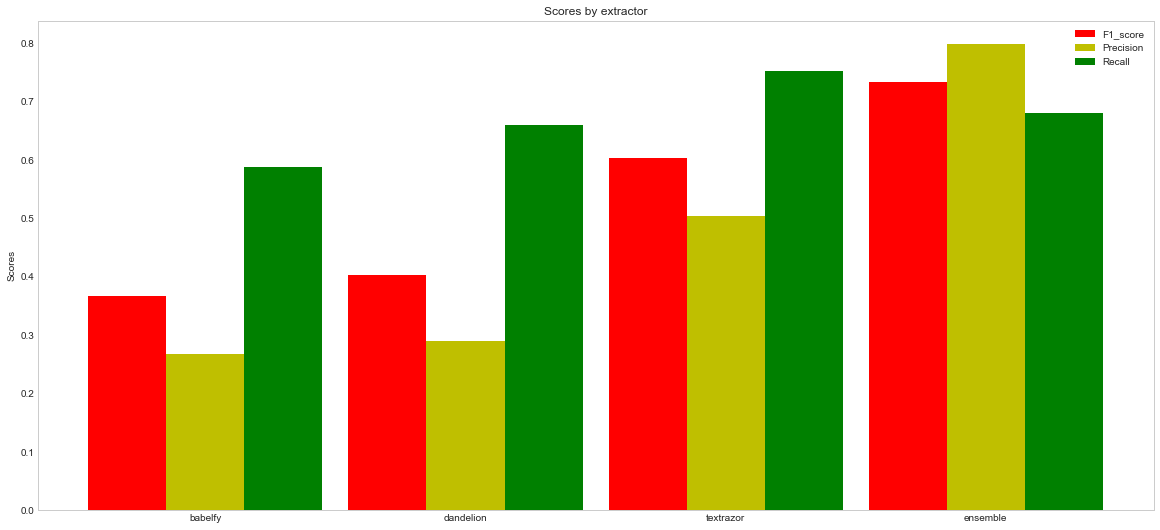

In [14]:
records_test = []
for ext in extractors_disambiguation:
    list_ext = getURIListExt(features_paths_test,ext)
    list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
    scores_disambiguation_obj = getScoresDisambiguation(gt_test_flatten,list_ext_flatten)
    scores_disambiguation_obj['extractor']=ext
    records_test.append(scores_disambiguation_obj)
    
score_combination['extractor'] = 'ensemble'
records_test.append(score_combination)
df_eval_ext_test=pd.DataFrame(records_test).round(2)

writer = pd.ExcelWriter('training_data/'+base+'/models/best_dis/evaluation/extracors_scores_test.xlsx')
df_eval_ext_test.to_excel(writer)
writer.save()
display(df_eval_ext_test)

x = [[r['f1'],r['precision'],r['recall']] for r in records_test]
path = 'training_data/'+base+'/models/best_dis/evaluation/hist.png'
ext_names = [r['extractor'] for r in records_test]
generateHistograM(x,path,ext_names)


,extractor,f1,precision,recall
0,babelfy,0.38,0.27,0.69
1,dandelion,0.42,0.29,0.77
2,textrazor,0.64,0.50,0.88
3,ensemble,0.80,0.80,0.79


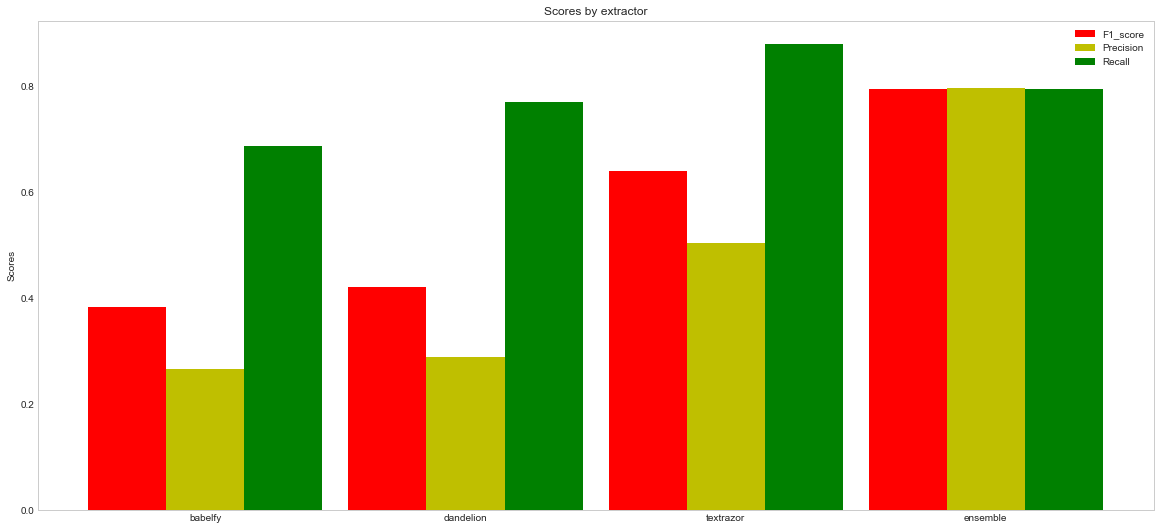

In [15]:
records_test = []
for ext in extractors_disambiguation:
    list_ext = getURIListExt(features_paths_test,ext)
    list_ext_flatten = reduce(lambda x,y: x+y,list_ext)
    scores_disambiguation_obj = getScoresDisambiguation(getBestResult(uris_list_per_extractor_test_flatten,gt_test_flatten),list_ext_flatten)
    scores_disambiguation_obj['extractor']=ext
    records_test.append(scores_disambiguation_obj)

score_combination_b['extractor'] = 'ensemble'
records_test.append(score_combination_b)
df_eval_ext_test=pd.DataFrame(records_test).round(2)

writer = pd.ExcelWriter('training_data/'+base+'/models/best_dis/evaluation/extracors_scores_test_b.xlsx')
df_eval_ext_test.to_excel(writer)
writer.save()
display(df_eval_ext_test)

x = [[r['f1'],r['precision'],r['recall']] for r in records_test]
path = 'training_data/'+base+'/models/best_dis/evaluation/hist_b.png'
ext_names = [r['extractor'] for r in records_test]
generateHistograM(x,path,ext_names)

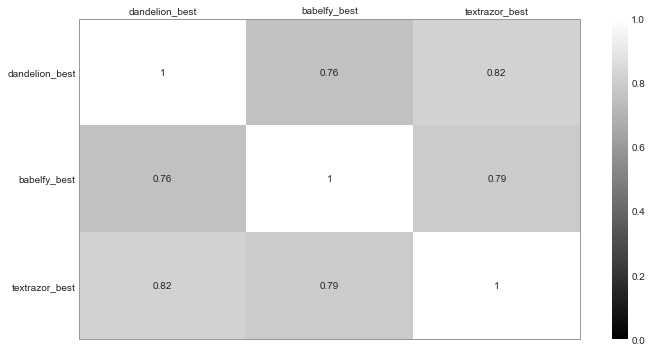

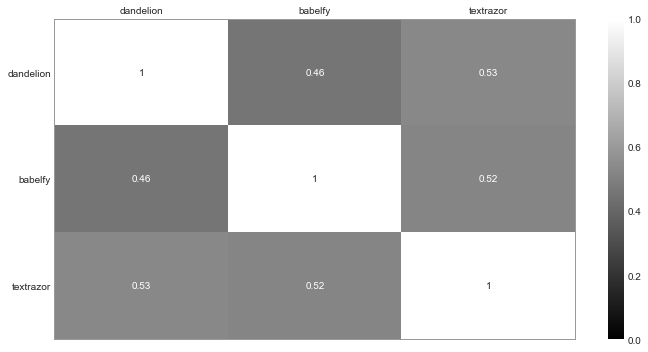

GT


,extractor,f1,precision,recall
0,GT,1.000000,1.000000,1.000000
1,GT_best,0.922082,0.855429,1.000000
2,dandelion,0.402523,0.659722,0.289614
3,dandelion_best,0.794979,0.659722,1.000000
4,babelfy,0.367208,0.588542,0.266853
5,babelfy_best,0.740984,0.588542,1.000000
6,textrazor,0.603456,0.752367,0.503751
7,textrazor_best,0.858687,0.752367,1.000000


GT_best


,extractor,f1,precision,recall
0,GT,0.922082,1.000000,0.855429
1,GT_best,1.000000,1.000000,1.000000
2,dandelion,0.421095,0.771218,0.289614
3,dandelion_best,0.870833,0.771218,1.000000
4,babelfy,0.384552,0.688007,0.266853
5,babelfy_best,0.815171,0.688007,1.000000
6,textrazor,0.640597,0.879520,0.503751
7,textrazor_best,0.935899,0.879520,1.000000


dandelion


,extractor,f1,precision,recall
0,GT,0.402523,0.289614,0.659722
1,GT_best,0.421095,0.289614,0.771218
2,dandelion,1.000000,1.000000,1.000000
3,dandelion_best,0.449148,0.289614,1.000000
4,babelfy,0.460450,0.453128,0.468012
5,babelfy_best,0.329039,0.207026,0.801287
6,textrazor,0.533562,0.441696,0.673676
7,textrazor_best,0.383854,0.255318,0.773023


dandelion_best


,extractor,f1,precision,recall
0,GT,0.794979,1.000000,0.659722
1,GT_best,0.870833,1.000000,0.771218
2,dandelion,0.449148,1.000000,0.289614
3,dandelion_best,1.000000,1.000000,1.000000
4,babelfy,0.329184,0.714833,0.213826
5,babelfy_best,0.755595,0.714833,0.801287
6,textrazor,0.540204,0.881579,0.389411
7,textrazor_best,0.823740,0.881579,0.773023


babelfy


,extractor,f1,precision,recall
0,GT,0.367208,0.266853,0.588542
1,GT_best,0.384552,0.266853,0.688007
2,dandelion,0.460450,0.468012,0.453128
3,dandelion_best,0.329184,0.213826,0.714833
4,babelfy,1.000000,1.000000,1.000000
5,babelfy_best,0.421285,0.266853,1.000000
6,textrazor,0.522934,0.438529,0.647575
7,textrazor_best,0.360386,0.241663,0.708412


babelfy_best


,extractor,f1,precision,recall
0,GT,0.740984,1.000000,0.588542
1,GT_best,0.815171,1.000000,0.688007
2,dandelion,0.329039,0.801287,0.207026
3,dandelion_best,0.755595,0.801287,0.714833
4,babelfy,0.421285,1.000000,0.266853
5,babelfy_best,1.000000,1.000000,1.000000
6,textrazor,0.511977,0.905605,0.356864
7,textrazor_best,0.794962,0.905605,0.708412


textrazor


,extractor,f1,precision,recall
0,GT,0.603456,0.503751,0.752367
1,GT_best,0.640597,0.503751,0.879520
2,dandelion,0.533562,0.673676,0.441696
3,dandelion_best,0.540204,0.389411,0.881579
4,babelfy,0.522934,0.647575,0.438529
5,babelfy_best,0.511977,0.356864,0.905605
6,textrazor,1.000000,1.000000,1.000000
7,textrazor_best,0.669993,0.503751,1.000000


textrazor_best


,extractor,f1,precision,recall
0,GT,0.858687,1.000000,0.752367
1,GT_best,0.935899,1.000000,0.879520
2,dandelion,0.383854,0.773023,0.255318
3,dandelion_best,0.823740,0.773023,0.881579
4,babelfy,0.360386,0.708412,0.241663
5,babelfy_best,0.794962,0.708412,0.905605
6,textrazor,0.669993,1.000000,0.503751
7,textrazor_best,1.000000,1.000000,1.000000


In [16]:
ext_obj_rel_test = getRelationshipExtractorDF_obj(uris_list_per_extractor_test_flatten,gt_test_flatten,display_flag=True,paths=[
    'training_data/'+base+'/models/best_dis/evaluation/sim_ext1.png',
    'training_data/'+base+'/models/best_dis/evaluation/sim_ext2.png'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
uris (InputLayer)            (None, 20)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 400)               8400      
_________________________________________________________________
dropout_27 (Dropout)         (None, 400)               0         
_________________________________________________________________
main_output (Dense)          (None, 1)                 401       
Total params: 8,801
Trainable params: 8,801
Non-trainable params: 0
_________________________________________________________________
None
Train on 8981 samples, validate on 2930 samples
Epoch 1/1000
8981/8981 [==============================] - 1s - loss: 0.1239 - mean_absolute_error: 0.2637 - acc: 0.8271 - val_loss: 0.1035 - val_mean_absolute_error: 0.2158 - val_acc: 0.8638
Epoch 2/1000
8981/8981 [====

8981/8981 [==============================] - 0s - loss: 0.1023 - mean_absolute_error: 0.2032 - acc: 0.8639 - val_loss: 0.1009 - val_mean_absolute_error: 0.1972 - val_acc: 0.8724
Epoch 21/1000
8981/8981 [==============================] - 0s - loss: 0.1023 - mean_absolute_error: 0.2026 - acc: 0.8626 - val_loss: 0.1001 - val_mean_absolute_error: 0.1968 - val_acc: 0.8741
Epoch 22/1000
8981/8981 [==============================] - 0s - loss: 0.1021 - mean_absolute_error: 0.2007 - acc: 0.8636 - val_loss: 0.0999 - val_mean_absolute_error: 0.1956 - val_acc: 0.8734
Epoch 23/1000
8981/8981 [==============================] - 0s - loss: 0.1028 - mean_absolute_error: 0.2029 - acc: 0.8633 - val_loss: 0.0994 - val_mean_absolute_error: 0.1964 - val_acc: 0.8737
Epoch 24/1000
8981/8981 [==============================] - 0s - loss: 0.1023 - mean_absolute_error: 0.2038 - acc: 0.8636 - val_loss: 0.0997 - val_mean_absolute_error: 0.1933 - val_acc: 0.8741
Epoch 25/1000
8981/8981 [=============================

8981/8981 [==============================] - 0s - loss: 0.1022 - mean_absolute_error: 0.2033 - acc: 0.8637 - val_loss: 0.0996 - val_mean_absolute_error: 0.1938 - val_acc: 0.8758
Epoch 43/1000
8981/8981 [==============================] - 0s - loss: 0.1029 - mean_absolute_error: 0.2023 - acc: 0.8642 - val_loss: 0.0997 - val_mean_absolute_error: 0.1944 - val_acc: 0.8734
Epoch 44/1000
8981/8981 [==============================] - 0s - loss: 0.1021 - mean_absolute_error: 0.2015 - acc: 0.8648 - val_loss: 0.0992 - val_mean_absolute_error: 0.1992 - val_acc: 0.8761
Epoch 45/1000
8981/8981 [==============================] - 0s - loss: 0.1020 - mean_absolute_error: 0.2032 - acc: 0.8643 - val_loss: 0.0993 - val_mean_absolute_error: 0.1977 - val_acc: 0.8734
Epoch 46/1000
8981/8981 [==============================] - 0s - loss: 0.1018 - mean_absolute_error: 0.2016 - acc: 0.8655 - val_loss: 0.0994 - val_mean_absolute_error: 0.1967 - val_acc: 0.8744
Epoch 47/1000
8981/8981 [=============================

8981/8981 [==============================] - 0s - loss: 0.1023 - mean_absolute_error: 0.2007 - acc: 0.8629 - val_loss: 0.0997 - val_mean_absolute_error: 0.1979 - val_acc: 0.8720
Epoch 65/1000
8981/8981 [==============================] - 0s - loss: 0.1016 - mean_absolute_error: 0.2020 - acc: 0.8644 - val_loss: 0.1011 - val_mean_absolute_error: 0.1997 - val_acc: 0.8710
Epoch 66/1000
8981/8981 [==============================] - 0s - loss: 0.1017 - mean_absolute_error: 0.2003 - acc: 0.8645 - val_loss: 0.1003 - val_mean_absolute_error: 0.2006 - val_acc: 0.8737
Epoch 67/1000
8981/8981 [==============================] - 0s - loss: 0.1021 - mean_absolute_error: 0.2029 - acc: 0.8646 - val_loss: 0.0997 - val_mean_absolute_error: 0.1974 - val_acc: 0.8737
Epoch 68/1000
8981/8981 [==============================] - 0s - loss: 0.1020 - mean_absolute_error: 0.2021 - acc: 0.8654 - val_loss: 0.0990 - val_mean_absolute_error: 0.1996 - val_acc: 0.8758
Epoch 69/1000
8981/8981 [=============================

1504/2930 [==============>...............] - ETA: 0s [0.099015328519478599, 0.19964326739107791, 0.87576791808873722]
{'precision': 0.7659574468085106, 'recall': 0.5987525987525988, 'f1': 0.6721120186697783}
{'precision': 0.7659574468085106, 'recall': 0.7236180904522613, 'f1': 0.7441860465116279}


In [93]:
s = '''from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense,Input,concatenate
from keras.layers import LSTM
from keras.layers import GRU,Concatenate
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys

from sklearn.metrics import f1_score as f1_score_func

from sklearn.metrics import accuracy_score

reg_alpha = 0.000
dropout = 0.45
dropout_input = 0.0
epochs=1000
batch=50
eg_alpha=0.0 
units=400
layers=2
#loss_function = 'categorical_crossentropy'
loss_function = 'mse'
optimizer = 'adam'
#activation = 'softmax'
activation = 'sigmoid'
activation_middle = 'selu'
architecture = 'simple'
patience = 50
dim_concatenation = 5


model_file_path = 'training_data/'+base+'/models/best_dis/model.h5'

class TestCallback(Callback):
    def __init__(self):
        self.history_scores = list()
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj
        x, y = model_obj['X_dict_test'],model_obj['Y_dict_test']
        val_loss = model.evaluate(x,y)[0]
        predicted_test = self.model.predict(x,verbose=0)
        score_obj = dict()


        score_obj['val_loss']=val_loss
        f1_score = f1_score_func(np.squeeze(model_obj['test_Y']),np.squeeze(predicted_test).round())
        score_obj['f1_score'] = f1_score

        print(score_obj,len(predicted_test))

        self.history_scores.append(score_obj)
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj['path'])

    def on_train_end(self,logs={}):
        global model_obj
        model_obj['history_scores'] = self.history_scores
        md = load_model(model_obj['path'])
        predicted_test = md.predict(model_obj['X_dict_test'],verbose=0)
        predicted_train= md.predict(model_obj['X_dict_train'],verbose=0)
        model_obj['predicted_train'] = predicted_train
        model_obj['predicted_test'] = predicted_test



model_obj['path'] = model_file_path
 
dim_in_1 = model_obj['train_X'].shape[-2]
dim_in_2 = model_obj['train_X'].shape[-1]
dim_out = model_obj['train_Y'].shape[-1]

def generateConcactPartSimple(X,ext_name):
    dim_input = X.shape[-1]
    input_tensor = Input(shape=(X.shape[-1],), name=ext_name)
    dense_middle = Dense(dim_concatenation, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha))(input_tensor)
    return input_tensor,dense_middle



X_dict_train = dict()
X_dict_train['uris'] = model_obj['train_X']

X_dict_test= dict()
X_dict_test['uris'] = model_obj['test_X']

uris_tensor = Input(shape=(dim_in_2,), name='uris')
for i in range(layers):
    concatenation = Dense(units, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha))(uris_tensor)
    concatenation = Dropout(dropout)(concatenation)
main_output = Dense(dim_out, activation=activation,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha), name='main_output')(concatenation)
model = Model(inputs=[uris_tensor], outputs=[main_output])

model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])
print(model.summary())
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

model_obj['X_dict_test'] = X_dict_test
model_obj['Y_dict_test'] = {'main_output': model_obj['test_Y']}
model_obj['X_dict_train'] = X_dict_train


model.fit(X_dict_train,
      {'main_output': model_obj['train_Y']},
      validation_data=(X_dict_test, 
             {'main_output': model_obj['test_Y']}),
      callbacks=[TestCallback(),early_stop],
      epochs=epochs, batch_size=batch)
    '''
print(s.replace('model_obj','md_obj'))

from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense,Input,concatenate
from keras.layers import LSTM
from keras.layers import GRU,Concatenate
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys

from sklearn.metrics import f1_score as f1_score_func

from sklearn.metrics import accuracy_score

reg_alpha = 0.000
dropout = 0.45
dropout_input = 0.0
epochs=1000
batch=50
eg_alpha=0.0 
units=